<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula05a_last_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

def plotDataset(X, y):
  plt.scatter(X[:,0], X[:,1], c=y)

In [2]:
def plotHiperplano(vector, intercept=0, dataset=None):
  xs = np.array([0, 1])
  ys = -(vector[0]*xs+intercept)/vector[1]
  plt.plot(xs, ys, 'r-')

In [3]:
def sign(a):
  return (a>=0)*2-1

In [4]:
import numpy as np
from sklearn.datasets import make_blobs

def criaDataset(n=40, func=lambda a, b: bool(a) != bool(b)):
  X, y = make_blobs(n_samples=n, centers=[[0,0],[1,0],[1,1],[0,1]], cluster_std=0.1)
  y = np.array([func(a>0.5, b>0.5) for a, b in zip(X[:,0], X[:,1])], dtype=int)*2-1
  return X, y

X, y = criaDataset()

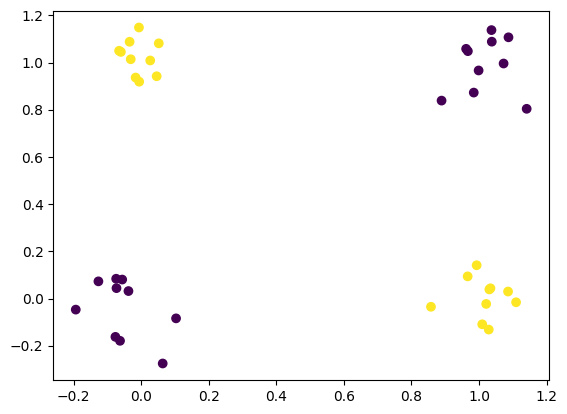

In [5]:
plotDataset(X, y)
plt.show()

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

In [7]:
from abc import ABC, abstractstaticmethod

class Cost(ABC):
  @abstractstaticmethod
  def getCost(y, ypred):
    pass
  @abstractstaticmethod
  def getGradient(y, ypred, X):
    pass

class WidrowHoff(Cost):
  @staticmethod
  def getCost(y, ypred):
    return np.sum((y-ypred)**2)
  @staticmethod
  def getGradient(y, ypred, X):
    return X.T @ (y-ypred)


In [9]:
include_bias = lambda X: np.c_[np.ones(X.shape[0]), X]

In [10]:
from scipy.special import expit

def tanh(a):
  return expit(a)*2-1

In [11]:
class XORClassifier(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    pass
  def predict(self, X):
    Xb = include_bias(X)
    ihw = np.array([[1.74, -0.9, 0.9], [1.74, 0.9, -0.9]]).T
    self.pH = Xb @ ihw
    self.H = tanh(self.pH)
    Hb = include_bias(self.H)
    how = np.array([1.234, -0.9, -0.9])
    ypred = Hb @ how
    return sign(ypred)

In [12]:
model = XORClassifier()
ypred = model.predict(X)
print(accuracy_score(y, ypred))

1.0


In [13]:
def defineAxes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

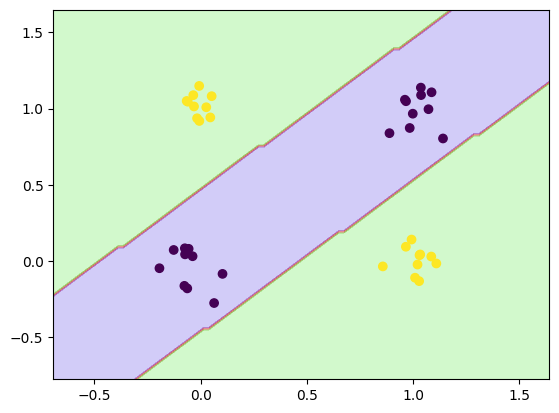

In [14]:
plotPredictions(model, X)
plotDataset(X, y)
plt.show()

0.975


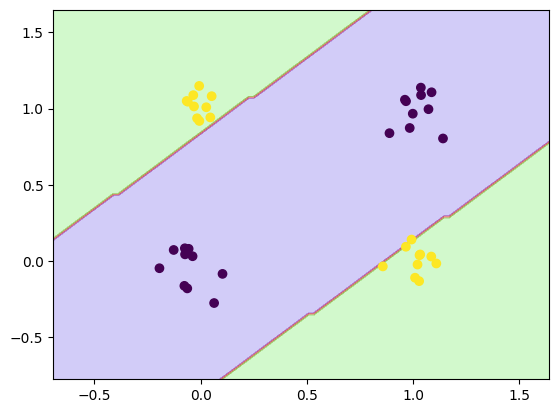

In [20]:
class XORLastLayer(BaseEstimator, ClassifierMixin):
  def __init__(self,
               max_iter=1000,
               learning_rate=0.001,
               regularization=0,
               cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def fit(self, X, y):
    Xb = include_bias(X)
    self.ihw = np.array([[1.74, -0.9, 0.9], [1.74, 0.9, -0.9]]).T
    pH = Xb @ self.ihw
    H = tanh(pH)
    Hb = include_bias(H)
    if len(y.shape) == 1:
      y = y.reshape(-1, 1)
    self.how = np.random.uniform(-1, 1, size=(Hb.shape[1], y.shape[1]))
    for _ in range(self.max_iter):
      ypred = Hb @ self.how
      error = y - ypred
      self.how *= 1 - self.regularization * self.learning_rate
      self.how += self.cost.getGradient(y, ypred, Hb) * self.learning_rate
      self.cost_ = self.cost.getCost(y, ypred)
    return self

  def predict(self, X):
    Xb = include_bias(X)
    pH = Xb @ self.ihw
    H = tanh(pH)
    Hb = include_bias(H)
    ypred = Hb @ self.how
    return sign(ypred)

model = XORLastLayer()
model.fit(X, y)
print(accuracy_score(y, model.predict(X)))
plotPredictions(model, X)
plotDataset(X, y)
plt.show()